In [9]:
import pandas as pd
import numpy as np

X_train = pd.read_csv("train.csv").drop(columns=["loan_status", "customer_id"])
y_train = pd.read_csv("train.csv")["loan_status"]

In [10]:
X_train.head()

,age,occupation_status,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,product_type,loan_intent,loan_amount,interest_rate,debt_to_income_ratio,loan_to_income_ratio,payment_to_income_ratio
0,40,Self-Employed,14.1,77335,679,4.4,67,17026,0,0,0,Personal Loan,Education,26200,12.04,0.220,0.339,0.113
1,18,Employed,0.0,34946,639,1.2,292,2620,0,1,0,Personal Loan,Education,37400,14.95,0.075,1.070,0.357
2,29,Employed,9.4,26778,595,5.5,191,4702,1,1,0,Personal Loan,Personal,52300,15.51,0.176,1.953,0.651
3,27,Student,1.5,25624,590,5.7,414,2609,0,0,0,Personal Loan,Debt Consolidation,4800,15.91,0.102,0.187,0.062
4,18,Employed,0.0,25676,568,1.8,19,3453,1,1,1,Personal Loan,Medical,24700,15.47,0.134,0.962,0.321


In [11]:

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      40000 non-null  int64  
 1   occupation_status        40000 non-null  object 
 2   years_employed           40000 non-null  float64
 3   annual_income            40000 non-null  int64  
 4   credit_score             40000 non-null  int64  
 5   credit_history_years     40000 non-null  float64
 6   savings_assets           40000 non-null  int64  
 7   current_debt             40000 non-null  int64  
 8   defaults_on_file         40000 non-null  int64  
 9   delinquencies_last_2yrs  40000 non-null  int64  
 10  derogatory_marks         40000 non-null  int64  
 11  product_type             40000 non-null  object 
 12  loan_intent              40000 non-null  object 
 13  loan_amount              40000 non-null  int64  
 14  interest_rate         

<Axes: xlabel='age', ylabel='annual_income'>

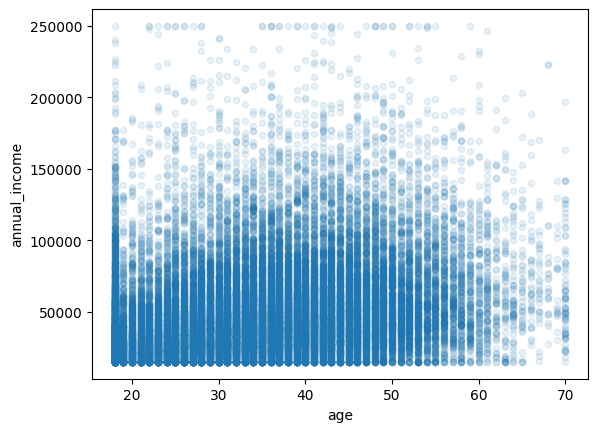

In [12]:
X_train.plot(x="age", y="annual_income", kind="scatter", alpha=0.1) 

In [13]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

# Final metric: 0.8999142250093201
preprocessing_pipeline1 = make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy="median"),
            StandardScaler()
        ),
        make_column_selector(dtype_include=np.number)
    ),
    (
        make_pipeline(
            OneHotEncoder()
        ),
        make_column_selector(dtype_include=object)
    )
)
random_forest1 = make_pipeline(preprocessing_pipeline1, RandomForestClassifier(n_estimators=10))

# Final metric: 0.9114727333529333
preprocessing_pipeline2 = make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy="median"),
            StandardScaler()
        ),
        make_column_selector(dtype_include=np.number)
    ),
    (
        make_pipeline(
            OneHotEncoder()
        ),
        make_column_selector(dtype_include=object)
    )
)
random_forest2 = make_pipeline(preprocessing_pipeline2, RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))

# Final metric: 0.9229709264204147
preprocessing_pipeline = make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy="median"),
            StandardScaler()
        ),
        make_column_selector(dtype_include=np.number)
    ),
    (
        make_pipeline(
            OneHotEncoder()
        ),
        make_column_selector(dtype_include=object)
    )
)

random_forest = make_pipeline(preprocessing_pipeline, XGBClassifier(
    n_estimators=80,
    max_depth=6,
    learning_rate=0.1,
    tree_method="hist",  
    device="cuda",      
    random_state=42,
))

trer_rmses = cross_val_score(random_forest, X_train, y_train, scoring="roc_auc", cv=3)

<Axes: >

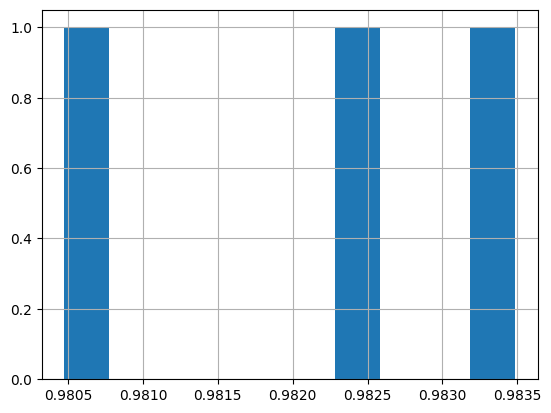

In [14]:
pd.Series(trer_rmses).hist()

In [15]:
random_forest.fit(X_train, y_train)

test = pd.read_csv("test.csv")

pred = random_forest.predict(test.drop(columns=["customer_id"]))

pd.concat([
    pd.DataFrame({
        "subtaskID": 1,
        "datapointID": test["customer_id"],
        "answer": test["age"].map(lambda val: "Young" if val < 30 else "Adult" if val < 60 else "Senior")
    }),
    pd.DataFrame({
        "subtaskID": 2,
        "datapointID": test["customer_id"],
        "answer": test["debt_to_income_ratio"].map(lambda val: "LowRisk" if val < 20 else "MediumRisk" if val < 40 else "HighRisk")
    }),
    pd.DataFrame({
        "subtaskID": 3,
        "datapointID": test["customer_id"],
        "answer": (test["current_debt"] + test["derogatory_marks"] + test["delinquencies_last_2yrs"]).map(lambda v: int(v)) 
    }),
    pd.DataFrame({
        "subtaskID": 4,
        "datapointID": test["customer_id"],
        "answer": pred 
    }),
]).to_csv("submission.csv")
